In [80]:
import numpy as np
from skimage.registration import phase_cross_correlation
from skimage.transform import rescale
import imageio.v3 as iio
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

In [81]:
def get_shift(i1, i2):
    # compute the cross-power spectrum of the two images:
    image_product = np.fft.fft2(i1) * np.fft.fft2(i2).conj()

    # compute the (not-normalized) cross-correlation between 
    # the two images:
    cc_image = np.fft.ifft2(image_product)

    # for visualization reasons, shift the zero-frequency 
    # component to the center of the spectrum:
    #cc_image_fftshift = np.fft.fftshift(cc_image)
    shape = i1.shape
    # find the peak in cc_image: 
    maxima = np.unravel_index(np.argmax(np.abs(cc_image)), shape)
    midpoints = np.array([np.fix(axis_size / 2) for axis_size in shape])
    float_dtype = image_product.real.dtype
    shifts = np.stack(maxima).astype(float_dtype, copy=False)
    shifts[shifts > midpoints] -= np.array(shape)[shifts > midpoints]
    #print(f"detected shifts: {shifts[1], shifts[0]}")
    return shifts


In [82]:
i1 = np.asarray(iio.imread(r"C:\Users\davidek\microscope_ui\controller\photo\1732940183.4493363\test.1732940286.2855325.png"))
i1 = cv2.cvtColor(i1, cv2.COLOR_RGB2GRAY)
i2 = np.asarray(iio.imread(r"C:\Users\davidek\microscope_ui\controller\photo\1732940183.4493363\test.1732940288.2155206.png"))
i2 = cv2.cvtColor(i2, cv2.COLOR_RGB2GRAY)

In [83]:
image = i1
offset_image = i2


In [84]:

# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image)
shift


array([0., 0.])

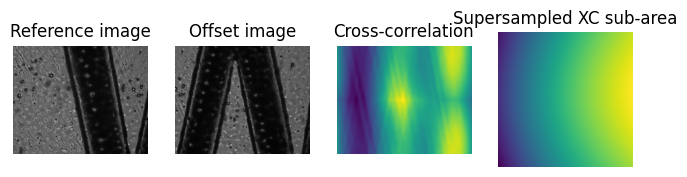

In [90]:

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 4, 1)
ax2 = plt.subplot(1, 4, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 4, 3)
ax4 = plt.subplot(1, 4, 4)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))

ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")


# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift * 100) + 75).conj()
ax4.imshow(cc_image.real)
ax4.set_axis_off()
ax4.set_title("Supersampled XC sub-area")
plt.show()

